## Commodity Project - Implementation of strategies on the Natural Gas futures

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data

In [2]:
data = pd.read_excel("/Users/thomascgd/Desktop/Esilv/A5/Commodities/Data_Commodities.xlsx",header=1,index_col=0,parse_dates=True)
data.head()

,BCOMNG6 Index,BCOMNG3 Index,BCOMCC6 Index,BCOMCC3 Index
Date,,,,
2013-01-02,24.7652,35.9070,220.8626,42.0876
2013-01-03,24.5039,35.4460,220.7660,42.0505
2013-01-04,25.0831,36.3788,217.3844,41.3821
2013-01-07,24.9559,36.1751,221.8287,42.2361
2013-01-08,24.6804,35.7033,216.7081,41.2707


In [3]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2763 entries, 2013-01-02 to 2023-12-20
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BCOMNG6 Index  2763 non-null   float64
 1   BCOMNG3 Index  2763 non-null   float64
 2   BCOMCC6 Index  2763 non-null   float64
 3   BCOMCC3 Index  2763 non-null   float64
dtypes: float64(4)
memory usage: 107.9 KB


#### Graphic of the Futures prices over time

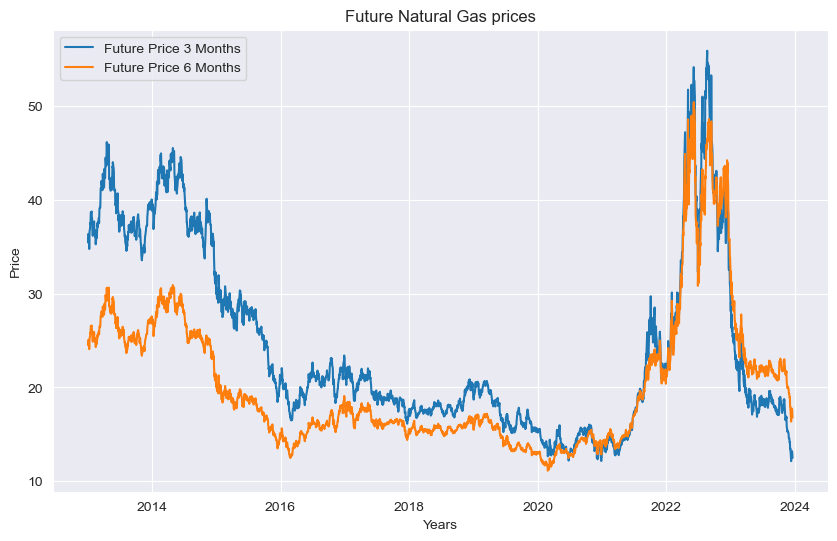

In [4]:
plt.figure(1,figsize=(10,6))
sns.set_style("darkgrid")

plt.plot(data["BCOMNG3 Index"],label='Future Price 3 Months')
plt.plot(data["BCOMNG6 Index"],label='Future Price 6 Months')
plt.xlabel('Years')
plt.ylabel('Price')
plt.legend()
plt.title("Future Natural Gas prices")
plt.show()

In [5]:
dfg = data.loc[:,["BCOMNG3 Index","BCOMNG6 Index"]]

dfg[["returns_NG_3","returns_NG_6"]]=dfg.pct_change()
dfg.dropna(inplace=True)

dfg["Spread_Price"] = dfg["BCOMNG6 Index"]-dfg["BCOMNG3 Index"]
dfg["CumR_NG3"]=dfg["returns_NG_3"].cumsum()
dfg["CumR_NG6"]=dfg["returns_NG_6"].cumsum()

dfg.head()

,BCOMNG3 Index,BCOMNG6 Index,returns_NG_3,returns_NG_6,Spread_Price,CumR_NG3,CumR_NG6
Date,,,,,,,
2013-01-03,35.4460,24.5039,-0.012839,-0.010551,-10.9421,-0.012839,-0.010551
2013-01-04,36.3788,25.0831,0.026316,0.023637,-11.2957,0.013477,0.013086
2013-01-07,36.1751,24.9559,-0.005599,-0.005071,-11.2192,0.007878,0.008015
2013-01-08,35.7033,24.6804,-0.013042,-0.011039,-11.0229,-0.005164,-0.003025
2013-01-09,34.7655,24.0871,-0.026266,-0.024039,-10.6784,-0.031431,-0.027064


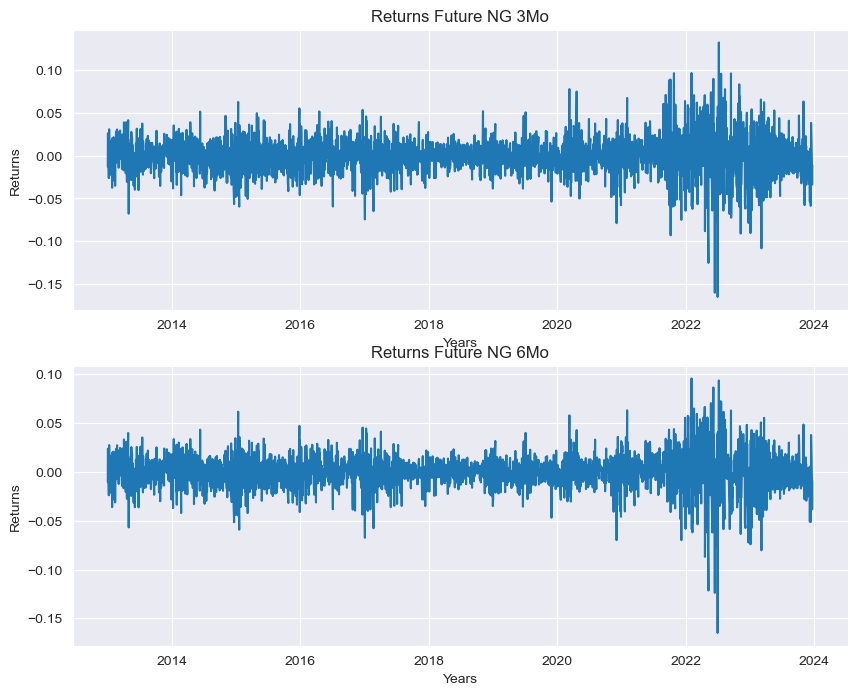

In [6]:
plt.figure(1,figsize=(10,8))
sns.set_style("darkgrid")

plt.subplot(2,1,1)
plt.plot(dfg["returns_NG_3"])
plt.xlabel('Years')
plt.ylabel("Returns")
plt.title("Returns Future NG 3Mo")

plt.subplot(2,1,2)
plt.plot(dfg["returns_NG_6"])
plt.xlabel('Years')
plt.ylabel("Returns")
plt.title("Returns Future NG 6Mo")

plt.show()

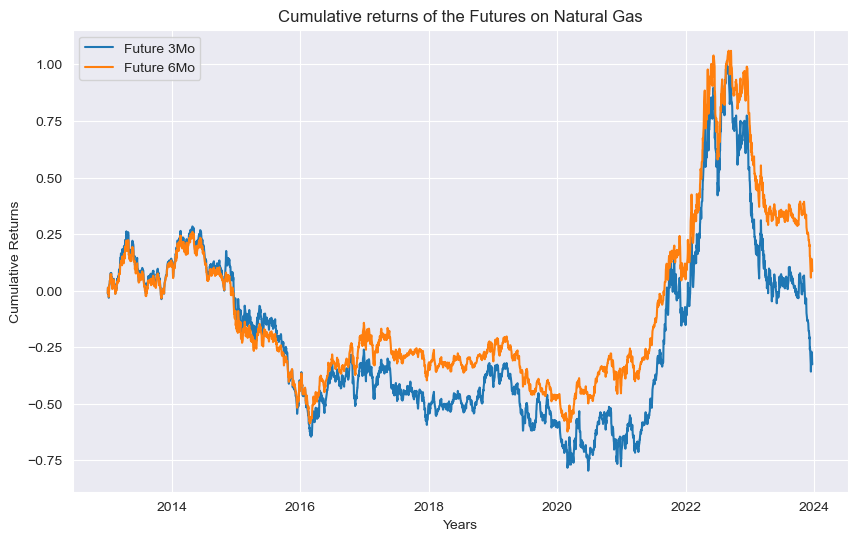

In [7]:
plt.figure(1,figsize=(10,6))
sns.set_style("darkgrid")

plt.plot(dfg["CumR_NG3"])
plt.plot(dfg["CumR_NG6"])
plt.xlabel('Years')
plt.ylabel("Cumulative Returns")
plt.legend(["Future 3Mo","Future 6Mo"])
plt.title("Cumulative returns of the Futures on Natural Gas")
plt.show()

In [38]:
def backtest_NG_mean_reverting(Pft: float =100, std_floor: float = 2, Rebalancement: int =1, Fenetre_rolling: int =40, Frais_transactions: float =0.001):
    '''
    Implementation of a mean-reverting strategy

    If the spread of the price diverge from it's mean and surpass the std_floor, 
    then we expose ourselve to the fact that the spread price will return to it's mean.
    '''
    PnL = 0
    w_f3 = 0
    w_f6 = 0

    number_of_opportunities = (len(dfg.index) - Fenetre_rolling) // Rebalancement
    number_of_time_strategies_in_place = 0
    avg_PnL_by_launch = 0

    Historique_Pft = [Pft]
    Historique_PnL = [PnL]
    Historique_w_f3 = [w_f3]
    Historique_w_f6 = [w_f6]

    Spread_mean = dfg["Spread_Price"].rolling(Fenetre_rolling).mean()
    Spread_std = dfg["Spread_Price"].rolling(Fenetre_rolling).std()

    for idx in range(Fenetre_rolling, len(dfg.index), Rebalancement):
        PnL = (w_f6*(dfg["returns_NG_6"].iloc[idx])+ w_f3*(dfg["returns_NG_3"].iloc[idx]))*Pft

        Pft+=PnL

        old_w_f3 = w_f3
        old_w_f6 = w_f6

        if dfg["Spread_Price"].iloc[idx] <= (Spread_mean.iloc[idx] - std_floor * Spread_std.iloc[idx]):
            w_f3,w_f6 = -0.5,0.5
            number_of_time_strategies_in_place +=1
            avg_PnL_by_launch +=PnL
        elif dfg["Spread_Price"].iloc[idx] >= (Spread_mean.iloc[idx] + std_floor * Spread_std.iloc[idx]):
            w_f3,w_f6 = 0.5,-0.5
            number_of_time_strategies_in_place +=1
            avg_PnL_by_launch +=PnL
        else:
            w_f3,w_f6=0,0

        if (old_w_f3 != w_f3) or (old_w_f6 != w_f6):
            Pft *= (1-Frais_transactions) 

        Historique_Pft.append(Pft)
        Historique_PnL.append(PnL)
        Historique_w_f3.append(w_f3)
        Historique_w_f6.append(w_f6)
        
    dfg_index_plot = dfg.index[Fenetre_rolling-1::Rebalancement]
    hit_ratio = round(number_of_time_strategies_in_place / number_of_opportunities *100, 3)
    avg_PnL_by_launch = round(avg_PnL_by_launch / number_of_time_strategies_in_place, 3)
    Stats = [hit_ratio, avg_PnL_by_launch, number_of_time_strategies_in_place, number_of_opportunities]

    Histo = pd.DataFrame(index=dfg_index_plot)
    Histo["Pft"]=Historique_Pft
    Histo["PnL"]=Historique_PnL
    Histo["Spread_mean"]=Spread_mean.dropna()
    Histo["wf3"]=Historique_w_f3
    Histo["wf6"]=Historique_w_f6

    return Histo, Stats



In [35]:
def backtest_NG_volatility(Pft: float =100, vol_percentile_floor: float = 0.75, Rebalancement: int =1, Fenetre_rolling: int =40, Frais_transactions: float =0.001):
    '''
    Implementation of a strategy based on the level of volatility, if the standard deviation is above a threshold,
    we short the spread, e.g we short the 6-months future and we buy the 3 months futures
    '''
    PnL = 0
    w_f3 = 0
    w_f6 = 0

    number_of_opportunities = (len(dfg.index) - Fenetre_rolling) // Rebalancement
    number_of_time_strategies_in_place = 0
    avg_PnL_by_launch = 0

    Historique_Pft = [Pft]
    Historique_PnL = [PnL]
    Historique_w_f3 = [w_f3]
    Historique_w_f6 = [w_f6]

    Spread_vol = dfg["Spread_Price"].rolling(Fenetre_rolling).std()
    Seuil_vol = Spread_vol.quantile(vol_percentile_floor)

    for idx in range(Fenetre_rolling, len(dfg.index), Rebalancement):
        PnL = (w_f6*(dfg["returns_NG_6"].iloc[idx])+ w_f3*(dfg["returns_NG_3"].iloc[idx]))*Pft

        Pft+=PnL

        old_w_f3 = w_f3
        old_w_f6 = w_f6

        if Spread_vol.iloc[idx] > Seuil_vol:
            w_f3 = -0.5
            w_f6 = 0.5
            number_of_time_strategies_in_place +=1
            avg_PnL_by_launch +=PnL
        else:
            w_f3 = 0
            w_f6 = 0

        if (old_w_f3 != w_f3) or (old_w_f6 != w_f6):
            Pft *= (1-Frais_transactions) 


        Historique_Pft.append(Pft)
        Historique_PnL.append(PnL)
        Historique_w_f3.append(w_f3)
        Historique_w_f6.append(w_f6)
        
    dfg_index_plot = dfg.index[Fenetre_rolling-1::Rebalancement]
    hit_ratio = round(number_of_time_strategies_in_place / number_of_opportunities *100, 3)
    avg_PnL_by_launch = round(avg_PnL_by_launch / number_of_time_strategies_in_place, 3)
    Stats = [hit_ratio, avg_PnL_by_launch, number_of_time_strategies_in_place, number_of_opportunities]

    Histo = pd.DataFrame(index=dfg_index_plot)
    Histo["Pft"]=Historique_Pft
    Histo["PnL"]=Historique_PnL
    Histo["Spread_std"]=Spread_vol.dropna()
    Histo["wf3"]=Historique_w_f3
    Histo["wf6"]=Historique_w_f6

    return Histo, Stats

In [10]:
def graph_backtest(df,taille=(10,8)):
    plt.figure(figsize=taille)

    for idx, col in enumerate(df.columns):
        plt.subplot(len(df.columns),1,idx+1)
        plt.plot(df[col])
        plt.ylabel(col)
    
    plt.show()

    return None


In [11]:
def metrics(df):
    
    annees = df.index.year.unique()
    Metrics = pd.DataFrame(index=annees)
    taux_sans_risque = 0.0
    cum_max = df["Pft"].cummax()
    daily_drawdowns = (df["Pft"]-cum_max)/cum_max

    Firsts = df.groupby(df.index.year)["Pft"].first()
    Lasts = df.groupby(df.index.year)["Pft"].last()

    Rendements_annuels_strategie = (Lasts-Firsts)/Firsts * 100
    volatilites_annuelles_strategie = df.groupby(df.index.year)["PnL"].std() * 100
    Sharpe_ratio_annuels = (Rendements_annuels_strategie-taux_sans_risque)/volatilites_annuelles_strategie
    annual_MDD = daily_drawdowns.groupby(df.index.year).min()

    Metrics["Rendements_annuels_pct"]=Rendements_annuels_strategie
    Metrics["volatilités_annuelles_pct"]=volatilites_annuelles_strategie
    Metrics["Sharpe_ratio_annuels"]=Sharpe_ratio_annuels
    Metrics["MDD_pct"] = annual_MDD * 100

    return Metrics

## Main

#### Implementation of the mean-reverting strategy

Hit ratio : 13.997%  | Average PnL each time we launch/continue the strategy : $-0.079
Number of time we are exposed : 381 | Number of oppourtunities to launch/continue the strategy : 2722


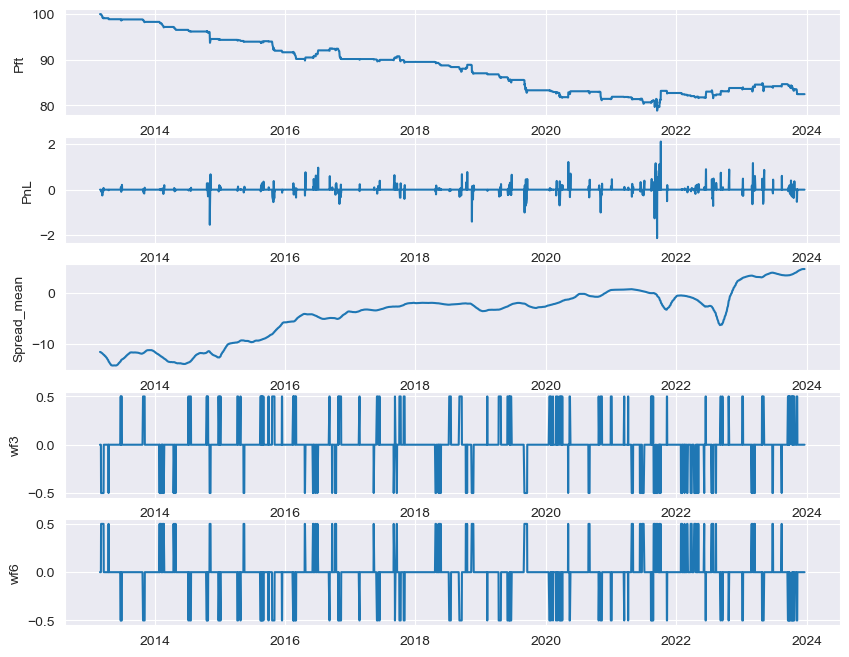

,Rendements_annuels_pct,volatilités_annuelles_pct,Sharpe_ratio_annuels,MDD_pct
Date,,,,
2013,-1.707124,3.643233,-0.468574,-1.775801
2014,-3.980804,12.349742,-0.322339,-6.293613
2015,-2.970749,7.426726,-0.400008,-8.373767
2016,-1.617757,12.602970,-0.128363,-10.184749
2017,-0.689370,7.723510,-0.089256,-10.668570
2018,-2.796671,12.225612,-0.228755,-13.077617
2019,-4.285246,12.352932,-0.346901,-17.258682
2020,-2.179685,14.083598,-0.154768,-18.898176
2021,1.478346,25.590756,0.057769,-21.175083


In [41]:
Histo_mean_reverting,Stats_mv = backtest_NG_mean_reverting(std_floor=2,Frais_transactions=0.001)
print(f"Hit ratio : {Stats_mv[0]}%  | Average PnL each time we launch/continue the strategy : ${Stats_mv[1]}")
print(f"Number of time we are exposed : {Stats_mv[2]} | Number of oppourtunities to launch/continue the strategy : {Stats_mv[3]}")
graph_backtest(Histo_mean_reverting)
Metrics_mean_reverting = metrics(Histo_mean_reverting)
Metrics_mean_reverting

#### Implementation of the volatility strategy

Hit ratio : 25.018%  | Average PnL each time we launch/continue the strategy : $0.013
Number of time we are exposed : 681 | Number of oppourtunities to launch/continue the strategy : 2722


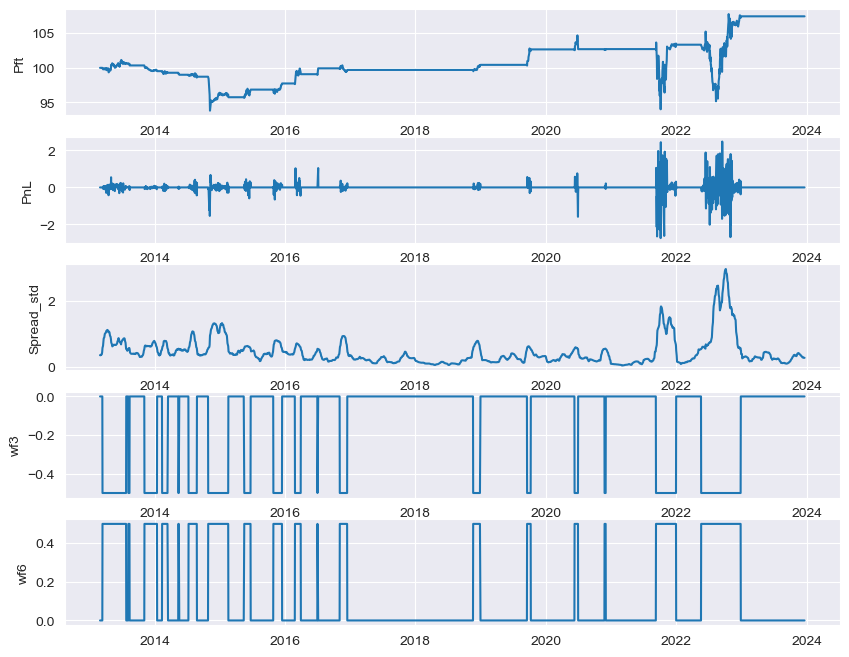

,Rendements_annuels_pct,volatilités_annuelles_pct,Sharpe_ratio_annuels,MDD_pct
Date,,,,
2013,-0.310634,9.194718,-0.033784,-1.595417
2014,-3.263327,16.895521,-0.193147,-7.244539
2015,1.546854,11.196634,0.138153,-5.421201
2016,1.999122,12.434211,0.160776,-3.456398
2017,0.000000,0.000000,NaN,-1.427801
2018,0.736530,3.678537,0.200224,-1.615759
2019,2.223724,7.203248,0.308711,-0.801085
2020,0.042693,12.463198,0.003425,-1.996753
2021,0.618019,57.838837,0.010685,-10.195667


In [42]:
Histo_volatility,Stats_vol = backtest_NG_volatility(vol_percentile_floor=0.75,Frais_transactions=0.001)
print(f"Hit ratio : {Stats_vol[0]}%  | Average PnL each time we launch/continue the strategy : ${Stats_vol[1]}")
print(f"Number of time we are exposed : {Stats_vol[2]} | Number of oppourtunities to launch/continue the strategy : {Stats_vol[3]}")
graph_backtest(Histo_volatility)
Metrics_volatility = metrics(Histo_volatility)
Metrics_volatility